In [1]:
%%bash
echo $PYTHONPATH

In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

import data_load
import data_process
import model
import train_model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from sklearn import preprocessing

DATA_PATH = "../data/Turbine_Data_Penmanshiel_11_2021-01-01_-_2021-07-01_1051.csv"
LOGS_PATH = "../data/Status_Penmanshiel_11_2021-01-01_-_2021-07-01_1051.csv"

data = data_load.load_turbine_data_without_time(DATA_PATH)
logs = data_load.load_turbine_logs_with_endtime(LOGS_PATH)
labels = data_load.get_data_label(data_load.load_turbine_data(DATA_PATH), logs)
# data_cols = data.columns[1:2]
# data = data[data_cols]
scaler = preprocessing.StandardScaler()
data_imputer = KNNImputer(n_neighbors=10)
data = data_process.impute_data(data)
data = data_process.standardize_data(data, scaler=scaler)
print(data.shape)
data = np.array(data, dtype='float32')

(26064, 299)


In [4]:
from sklearn.model_selection import train_test_split

epochs = 30
k = 10

i = 0
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1)
# for train, test in kf.split(data):
#     ae_model = model.AutoEncoder(input_size=np.size(data, axis=1)).to(device)
#     loss = nn.MSELoss()
#     # optimizer = torch.optim.SGD(ae_model.parameters(), lr=0.001)
#     optimizer = torch.optim.Adam(ae_model.parameters(), lr=0.0015)
#     train_labels = labels[train]
#     test_labels = labels[test]
#     X_train, X_test = data[train][train_labels==0], data[test]
#     for epoch in range(epochs):
#         print(f"\n=====epoch {epoch}/{epochs}=====")
#         train_model.train(data_x=X_train, data_y=X_train, model=ae_model, loss_fn=loss, optimizer=optimizer,
#                           batch_size=30000)
#
#     res = train_model.autoencoder_test(X_test, X_test, ae_model, 1000)
#     i += 1
#     if i == 1:
#         break
X_train_raw = X_train
X_train = X_train[y_train == 0]

ae_model = model.AutoEncoder(input_size=np.size(data, axis=1)).to(device)
loss = nn.MSELoss()
# optimizer = torch.optim.SGD(ae_model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(ae_model.parameters(), lr=0.0015)

for epoch in range(epochs):
    print(f"\n=====epoch {epoch}/{epochs}=====")
    train_model.train(data_x=X_train, data_y=X_train, model=ae_model, loss_fn=loss, optimizer=optimizer,
                      batch_size=30000)

res = train_model.autoencoder_test(X_test, X_test, ae_model, 1000)


=====epoch 0/30=====
loss: 0.773837  [21870/21870]

=====epoch 1/30=====
loss: 0.772384  [21870/21870]

=====epoch 2/30=====
loss: 0.771168  [21870/21870]

=====epoch 3/30=====
loss: 0.769958  [21870/21870]

=====epoch 4/30=====
loss: 0.768503  [21870/21870]

=====epoch 5/30=====
loss: 0.766519  [21870/21870]

=====epoch 6/30=====
loss: 0.763750  [21870/21870]

=====epoch 7/30=====
loss: 0.759877  [21870/21870]

=====epoch 8/30=====
loss: 0.754406  [21870/21870]

=====epoch 9/30=====
loss: 0.746654  [21870/21870]

=====epoch 10/30=====
loss: 0.735332  [21870/21870]

=====epoch 11/30=====
loss: 0.719156  [21870/21870]

=====epoch 12/30=====
loss: 0.697033  [21870/21870]

=====epoch 13/30=====
loss: 0.667785  [21870/21870]

=====epoch 14/30=====
loss: 0.630869  [21870/21870]

=====epoch 15/30=====
loss: 0.587864  [21870/21870]

=====epoch 16/30=====
loss: 0.545879  [21870/21870]

=====epoch 17/30=====
loss: 0.521312  [21870/21870]

=====epoch 18/30=====
loss: 0.518565  [21870/21870]

==

0.9382841966656995


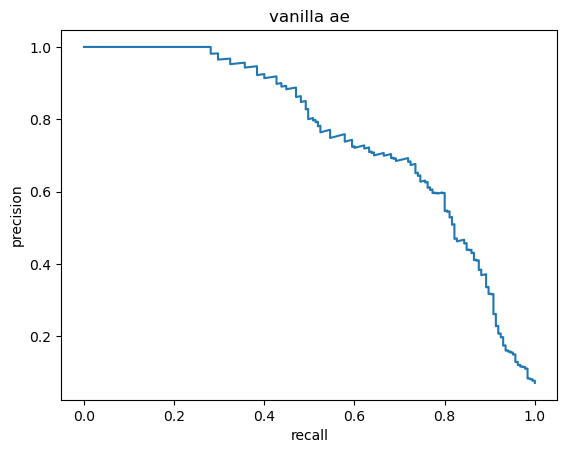

In [5]:
import sklearn.metrics as metrics

res_sorted = np.sort(res)
res_cdf = 1. * np.arange(len(res)) / (len(res) - 1)
point_color = ["red" if label == 1 else "blue" for label in y_test]
point_size = [0.1 if label == 0 else 10 for label in y_test]
# plt.hist(res, bins=200)
# plt.scatter(res, range(res.size), s=point_size, c=point_color)

fpr, tpr, _ = metrics.roc_curve(y_test, res)

precision, recall, threshold = metrics.precision_recall_curve(y_test, res)

# precision = precision[0:-3]
#
# recall = recall[0:-3]

plt.plot(recall, precision)

# print(precision, recall)

print(metrics.auc(fpr, tpr))
# print(metrics.auc(precision, recall))

# print(metrics.f1_score(test_labels, res))

# plt.scatter(res_sorted, range(res.size), s=point_size, c=point_color)
# plt.xlim(0, 150)
plt.ylabel("precision")
plt.xlabel("recall")
plt.title("vanilla ae")
plt.show()

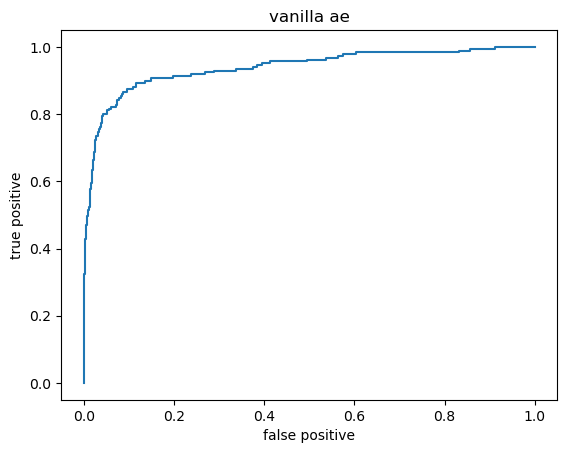

In [6]:
plt.plot(fpr, tpr)
plt.xlabel("false positive")
plt.ylabel("true positive")
plt.title("vanilla ae")
plt.show()

In [7]:
from alibi.explainers.cfrl_tabular import CounterfactualRLTabular, CounterfactualRL
from alibi.explainers.backends.cfrl_tabular import get_he_preprocessor

raw_data = data_load.load_turbine_data_without_time(DATA_PATH)
feature_names = raw_data.columns.tolist()

ae_preprocessor, ae_inv_preprocessor = get_he_preprocessor(X=X_train_raw, feature_names=feature_names, category_map={})

ae = model.AutoEncoder(input_size=np.size(data, axis=1)).to(device)
# ae_loss = nn.MSELoss()
# # optimizer = torch.optim.SGD(ae_model.parameters(), lr=0.001)
# ae_optimizer = torch.optim.Adam(ae_model.parameters(), lr=0.0015)
# 
# for epoch in range(epochs):
#     print(f"\n=====epoch {epoch}/{epochs}=====")
#     train_model.train(data_x=X_train_raw, data_y=X_train_raw, model=ae_model, loss_fn=ae_loss, optimizer=ae_optimizer,
#                       batch_size=30000)


def predict_function(x):
    distance = train_model.autoencoder_test(x, x, ae_model, len(x))
    res = 1 / (1 + np.exp(-(distance-65)))
    return torch.tensor([[1-n, n] for n in res])
    # return res

# explainer = CounterfactualRLTabular(
#     predictor=predict_function,
#     encoder=ae.encoder,
#     decoder=ae.decoder,
#     feature_names=feature_names,
#     category_map={},
#     latent_dim=20,
#     encoder_preprocessor=ae_preprocessor,
#     decoder_inv_preprocessor=ae_inv_preprocessor,
#     coeff_sparsity=0.5,
#     coeff_consistency=0.5,
#     backend="pytorch"
# )

explainer = CounterfactualRL(
    predictor=predict_function,
    encoder=ae.encoder,
    decoder=ae.decoder,
    coeff_consistency=0.5,
    coeff_sparsity=0.5,
    backend='pytorch'
)

print(X_train[0:100].size)



C:\Users\sxf84\.conda\envs\windTurbineExp\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
C:\Users\sxf84\.conda\envs\windTurbineExp\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_

29900


Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.


In [8]:
explainer = explainer.fit(X=X_train[0:100])

  0%|          | 0/100000 [00:05<?, ?it/s]


RuntimeError: DataLoader worker (pid(s) 6392, 30048, 22840, 35648) exited unexpectedly

In [ ]:
X_positive = X_test[np.argmax(predict_function(X_test), axis=1) == 1]
X = X_positive[:1000]
Y_t = np.array([0])

C=[]
explainer.explain(X, Y_t)